In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
import re
import asyncio
import pandas as pd
from typing import List, Tuple, Dict, Any, Optional
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.prebuilt import create_react_agent
from langchain.chat_models import init_chat_model
from langchain.schema import AIMessage
from collections import defaultdict


class MultiDatabaseMCPGraphEvaluator:
    def __init__(
        self, 
        evaluation_prompt: str, 
        namespace: str = "graph",
        agent_model: str = "anthropic:claude-3-7-sonnet-latest",
        evaluation_llm: Optional[Any] = None,
        evaluation_model: str = "anthropic:claude-3-5-haiku-latest",
        evaluation_model_kwargs: Optional[Dict[str, Any]] = None,
        max_concurrent: int = 5
    ):
        """
        Initialize the Multi-Database MCP Graph Evaluator
        
        Args:
            evaluation_prompt: The prompt template for evaluating answers
            namespace: The namespace for the MCP server (default: "graph")
            agent_model: The model to use for the agent
            evaluation_llm: Pre-configured LLM instance for evaluation
            evaluation_model: The model to use for evaluation if evaluation_llm is None
            evaluation_model_kwargs: Additional kwargs for init_chat_model
            max_concurrent: Maximum number of concurrent evaluations (default: 5)
        """
        self.evaluation_prompt = evaluation_prompt
        self.namespace = namespace
        self.agent_model = agent_model
        self.max_concurrent = max_concurrent
        
        # Store evaluators for each database
        self.evaluators = {}
        
        # Handle evaluation LLM
        if evaluation_llm is not None:
            self.llm = evaluation_llm
        else:
            model_kwargs = evaluation_model_kwargs or {}
            self.llm = init_chat_model(evaluation_model, **model_kwargs)
    
    def get_custom_mcp_config(self, database: str) -> Dict[str, Any]:
        """Generate MCP config for a specific database"""
        return {
            "neo4j-graph": {
                "command": "uvx",
                "args": ["mcp-neo4j-cypher@0.2.4", "--namespace", self.namespace],
                "transport": "stdio",
                "env": {
                    "NEO4J_URI": "neo4j+s://demo.neo4jlabs.com",
                    "NEO4J_USERNAME": database, 
                    "NEO4J_PASSWORD": database,
                    "NEO4J_DATABASE": database
                }
            }
        }
    
    async def get_evaluator_for_database(self, database: str):
        """Get or create an evaluator for a specific database"""
        if database not in self.evaluators:
            # Create new evaluator with database-specific config
            evaluator = MCPGraphEvaluator(
                evaluation_prompt=self.evaluation_prompt,
                mcp_config=self.get_custom_mcp_config(database),
                namespace=self.namespace,
                agent_model=self.agent_model,
                evaluation_llm=self.llm,
                max_concurrent=self.max_concurrent
            )
            await evaluator.initialize()
            self.evaluators[database] = evaluator
        
        return self.evaluators[database]
    
    async def evaluate_dataset(self, df: pd.DataFrame) -> List[Dict[str, Any]]:
        """
        Evaluate dataset with multiple databases
        
        Args:
            df: DataFrame with columns including 'database', 'question', 'answer'
        
        Returns:
            List of evaluation results
        """
        # Group records by database
        grouped_records = defaultdict(list)
        for _, row in df.iterrows():
            database = row['database']
            record = row.to_dict()
            grouped_records[database].append(record)
        
        # Process each database group
        all_results = []
        
        for database, records in grouped_records.items():
            print(f"Processing {len(records)} records for database: {database}")
            
            # Get evaluator for this database
            evaluator = await self.get_evaluator_for_database(database)
            
            # Process records for this database
            database_results = await evaluator.evaluate_dataset(records)
            all_results.extend(database_results)
        
        return all_results


# Your original MCPGraphEvaluator class (needed for the multi-database evaluator)
class MCPGraphEvaluator:
    def __init__(
        self, 
        evaluation_prompt: str, 
        mcp_config: Optional[Dict[str, Any]] = None,
        neo4j_config: Optional[Dict[str, str]] = None,
        namespace: str = "graph",
        agent_model: str = "anthropic:claude-3-7-sonnet-latest",
        evaluation_llm: Optional[Any] = None,
        evaluation_model: str = "anthropic:claude-3-5-haiku-latest",
        evaluation_model_kwargs: Optional[Dict[str, Any]] = None,
        max_concurrent: int = 5
    ):
        self.client = None
        self.agent = None
        self.evaluation_prompt = evaluation_prompt
        self.namespace = namespace
        self.agent_model = agent_model
        self.max_concurrent = max_concurrent
        
        # Handle MCP configuration
        if mcp_config is not None:
            self.mcp_config = mcp_config
        elif neo4j_config is not None:
            self.mcp_config = {
                "neo4j-graph": {
                    "command": "uvx",
                    "args": ["mcp-neo4j-cypher@0.2.4", "--namespace", self.namespace],
                    "transport": "stdio",
                    "env": neo4j_config
                }
            }
        else:
            raise ValueError("Either mcp_config or neo4j_config must be provided")
        
        # Handle evaluation LLM
        if evaluation_llm is not None:
            self.llm = evaluation_llm
        else:
            model_kwargs = evaluation_model_kwargs or {}
            self.llm = init_chat_model(evaluation_model, **model_kwargs)
    
    async def initialize(self):
        """Initialize the MCP client and agent"""
        self.client = MultiServerMCPClient(self.mcp_config)
        tools = await self.client.get_tools()
        self.agent = create_react_agent(self.agent_model, tools)
    
    async def extract_tool_calls_and_final_answer(self, input_question: str) -> Tuple[List[Dict[str, Any]], str]:
        """Extract tool calls and final answer from agent response"""
        tool_calls = []
        final_answer = ""
        
        data = await self.agent.ainvoke({
            "messages": [{"role": "user", "content": input_question}]
        })
        
        for message in data["messages"]:
            if isinstance(message, AIMessage):
                if hasattr(message, "tool_calls") and message.tool_calls:
                    tool_calls.extend(message.tool_calls)
                elif isinstance(message.content, str) and message.content.strip():
                    final_answer = message.content
        
        return tool_calls, final_answer
    
    def extract_score_and_reasoning(self, text: str) -> Tuple[float, str]:
        """Extract score and reasoning from XML tags in text"""
        score_pattern = r'<score>(.*?)</score>'
        reasoning_pattern = r'<reasoning>(.*?)</reasoning>'
        
        score_match = re.search(score_pattern, text, re.IGNORECASE | re.DOTALL)
        reasoning_match = re.search(reasoning_pattern, text, re.IGNORECASE | re.DOTALL)
        
        score = None
        if score_match:
            try:
                score = float(score_match.group(1).strip())
            except ValueError:
                pass
        
        reasoning = reasoning_match.group(1).strip() if reasoning_match else None
        
        return (score, reasoning)
    
    async def evaluate_answer(self, record: Dict[str, str]) -> str:
        """Evaluate a generated answer against the reference answer"""
        messages = [
            ("human", self.evaluation_prompt.format(
                question=record["question"], 
                reference=record["answer"], 
                generated_answer=record["generated_answer"]
            )),
        ]
        response = await self.llm.ainvoke(messages)
        return response.content
    
    async def evaluate_record(self, record: Dict[str, str]) -> Dict[str, Any]:
        """Process a single record: generate answer and evaluate it"""
        tools, generated_answer = await self.extract_tool_calls_and_final_answer(record["question"])
        
        record['tools'] = tools
        record['generated_answer'] = generated_answer
        
        evaluation_result = await self.evaluate_answer(record)
        score, reasoning = self.extract_score_and_reasoning(evaluation_result)
        
        record['evaluation_score'] = score
        record['evaluation_reasoning'] = reasoning
        record['evaluation_raw'] = evaluation_result
        
        return record
    
    async def evaluate_dataset(self, dataset: List[Dict[str, str]]) -> List[Dict[str, Any]]:
        """Evaluate an entire dataset with concurrency control"""
        # Create semaphore to limit concurrent operations
        semaphore = asyncio.Semaphore(self.max_concurrent)
        
        async def process_record_with_semaphore(record):
            async with semaphore:
                try:
                    result = await self.evaluate_record(record.copy())
                    return result
                except Exception as e:
                    print(f"Error processing record: {e}")
                    record['error'] = str(e)
                    return record
        
        tasks = [process_record_with_semaphore(record) for record in dataset]
        results = await asyncio.gather(*tasks)
        
        return results

In [3]:
df = pd.read_json("../generate_eval_dataset/generated_dataset.json")
print(len(df))
df.head()

205


,question,cypher,query_type,complexity,noise_applied,model,database,validated,result,answer,noise_type
0,What's Microsoft Corporation's revenue?,MATCH (o:Organization {name: 'Microsoft Corpor...,Direct Property Access,0-hop,False,anthropic-chat,companies,True,[{'company_revenue': 198270000000.0}],"According to the data, Microsoft Corporation's...",NaN
1,How many employees does SAP have?,MATCH (o:Organization {name: 'SAP'}) RETURN o....,Direct Property Access,0-hop,False,anthropic-chat,companies,True,[{'employee_count': 111961}],"According to the data, SAP has 111,961 employees.",NaN
2,Tell me Mircosoft Corporation's motto,MATCH (o:Organization {name: 'Microsoft Corpor...,Direct Property Access,0-hop,True,anthropic-chat,companies,True,[{'company_motto': 'We’re on a mission to empo...,"Microsoft Corporation's motto is: ""We're on a ...",typo
3,Is Cloud Sherpas still active?,MATCH (o:Organization {name: 'Cloud Sherpas'})...,Direct Property Access,0-hop,False,anthropic-chat,companies,True,[{'is_dissolved': True}],"No, Cloud Sherpas is not still active. The que...",NaN
4,What's the revenue of New Energy Group?,MATCH (o:Organization {name: 'New Energy Group...,Direct Property Access,0-hop,False,anthropic-chat,companies,True,[{'company_revenue': 120000000.0}],"The revenue of New Energy Group is $120,000,000.",NaN


In [4]:
evaluation_prompt = """You are an answer evaluation system. Compare the generated answer against the real answer and output only a single decimal score between 0 and 1.

Scoring criteria:
- 1.0: Generated answer is completely accurate and comprehensive
- 0.8-0.9: Mostly accurate with minor omissions or slight inaccuracies
- 0.6-0.7: Generally accurate but missing important details or contains some errors
- 0.4-0.5: Partially accurate with significant gaps or notable errors
- 0.2-0.3: Largely inaccurate with only some correct elements
- 0.0-0.1: Completely inaccurate or irrelevant

Consider both factual accuracy and completeness. Penalize hallucinations, contradictions, and missing key information.

Input format:
Question: {question}
Real answer: {reference}
Generated answer: {generated_answer}

Output format:
<reasoning>...</reasoning>
<score>0.4</score>
"""

In [5]:
evaluator = MultiDatabaseMCPGraphEvaluator(
    evaluation_prompt=evaluation_prompt,
    namespace="custom",
    agent_model="openai:gpt-4o",
    evaluation_model="anthropic:claude-3-5-haiku-latest"
)

In [6]:
results = await evaluator.evaluate_dataset(df)

Processing 35 records for database: companies
Processed: What's the revenue of New Energy Group?...
Processed: Tell me Mircosoft Corporation's motto...
Processed: How many employees does SAP have?...
Processed: What's Microsoft Corporation's revenue?...
Processed: Is Cloud Sherpas still active?...
Processed: Is Microsoft Corporation a publicly traded company...
Processed: How many subsidiaries does Accenture have?...
Processed: Who's the CEO of Accenture?...
Processed: How many folks work at Cloud Sherpas?...
Processed: Which firm acquired Cloud Sherpas?...
Processed: How many investors does Infinite Analytics have?...
Processed: How many suppliers does IBM have?...
Processed: What country is Topsfield located in?...
Processed: How many articles mention New Energy Group?...
Processed: What's the name of the biz that owns IBM Research?...
Processed: How many board members does Microsft Corporation h...
Processed: How many companys does SAP own in the United State...
Processed: What's th

In [7]:
results[0]

{'question': "What's Microsoft Corporation's revenue?",
 'cypher': "MATCH (o:Organization {name: 'Microsoft Corporation'}) RETURN o.revenue AS company_revenue",
 'query_type': 'Direct Property Access',
 'complexity': '0-hop',
 'noise_applied': False,
 'model': 'anthropic-chat',
 'database': 'companies',
 'validated': True,
 'result': [{'company_revenue': 198270000000.0}],
 'answer': "According to the data, Microsoft Corporation's revenue is $198,270,000,000.",
 'noise_type': nan,
 'tools': [],
 'generated_answer': "As of the last fiscal year ending in June 2023, Microsoft Corporation reported a total revenue of approximately $211.9 billion. Please note that financial figures like revenue are subject to change with new financial reports, so it's advisable to refer to the latest official financial statements or news releases for the most current information.",
 'evaluation_score': 0.7,
 'evaluation_reasoning': "Comparing the generated answer with the real answer:\n- Generated answer prov

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Dict, Any

def analyze_evaluation_scores(records: List[Dict[str, Any]], figsize: tuple = (12, 8)):
    """
    Analyze and visualize evaluation score distributions.
    
    Parameters:
    -----------
    records : List[Dict]
        List of evaluation records with 'evaluation_score', 'noise_type', 'model', 
        'complexity', 'query_type', 'noise_applied' keys
    figsize : tuple
        Figure size for plots
    
    Returns:
    --------
    pd.DataFrame: Processed dataframe
    """
    
    # Convert to DataFrame and clean data
    df = pd.DataFrame(records)
    df['evaluation_score'] = pd.to_numeric(df['evaluation_score'], errors='coerce')
    df['noise_applied'] = df['noise_applied'].fillna(False)
    df['noise_type'] = df['noise_type'].fillna('No Noise')
    
    for col in ['model', 'complexity', 'query_type']:
        if col in df.columns:
            df[col] = df[col].fillna('Unknown')
    
    # Print key stats
    print(f"Dataset: {len(df)} records | Range: {df['evaluation_score'].min():.2f}-{df['evaluation_score'].max():.2f} | Mean: {df['evaluation_score'].mean():.3f}")
    
    # Set style
    sns.set_style("whitegrid")
    sns.set_palette("muted")
    
    # 2x2 grid comprehensive plot
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Overall distribution with key stats
    sns.histplot(data=df, x='evaluation_score', bins=20, kde=True, ax=axes[0,0], 
                alpha=0.7, color='steelblue')
    mean_score = df['evaluation_score'].mean()
    axes[0,0].axvline(mean_score, color='darkred', linestyle='--', linewidth=2, 
                      label=f'Mean: {mean_score:.3f}')
    axes[0,0].set_title('Score Distribution', fontweight='bold')
    axes[0,0].legend()
    
    # 2. Key comparison: noise impact
    sns.boxplot(data=df, x='noise_applied', y='evaluation_score', ax=axes[0,1],
               palette=['lightblue', 'lightcoral'])
    
    # Add means as red diamonds
    means = df.groupby('noise_applied')['evaluation_score'].mean()
    for i, mean_val in enumerate(means):
        axes[0,1].scatter(i, mean_val, color='darkred', s=100, marker='D', zorder=10)
    
    # Add sample sizes to labels
    noise_counts = df['noise_applied'].value_counts()
    labels = [f'No Noise\n(n={noise_counts[False]})', f'With Noise\n(n={noise_counts[True]})']
    axes[0,1].set_xticklabels(labels)
    axes[0,1].set_title('Impact of Noise', fontweight='bold')
    
    # 3. Complexity comparison
    if 'complexity' in df.columns and df['complexity'].nunique() > 1:
        complexity_order = sorted(df['complexity'].unique())
        sns.boxplot(data=df, x='complexity', y='evaluation_score', ax=axes[1,0],
                   palette='viridis', order=complexity_order)
        
        # Add means as red diamonds
        complexity_means = df.groupby('complexity')['evaluation_score'].mean()
        for i, complexity in enumerate(complexity_order):
            mean_val = complexity_means[complexity]
            axes[1,0].scatter(i, mean_val, color='darkred', s=100, marker='D', zorder=10)
        
        # Add sample sizes to labels
        complexity_counts = df['complexity'].value_counts()
        labels = [f'{comp}\n(n={complexity_counts[comp]})' for comp in complexity_order]
        axes[1,0].set_xticklabels(labels)
        axes[1,0].set_title('Performance by Complexity', fontweight='bold')
        axes[1,0].set_xlabel('Complexity Level')
    else:
        axes[1,0].text(0.5, 0.5, 'No complexity\ndata available', 
                       transform=axes[1,0].transAxes, ha='center', va='center',
                       fontsize=12, style='italic')
        axes[1,0].set_title('Performance by Complexity', fontweight='bold')
    
    # 4. Model comparison
    if 'model' in df.columns and df['model'].nunique() > 1:
        # Multiple models - show comparison
        model_order = sorted(df['model'].unique())
        sns.boxplot(data=df, x='model', y='evaluation_score', ax=axes[1,1],
                   palette='Set2', order=model_order)
        
        # Add means as red diamonds
        model_means = df.groupby('model')['evaluation_score'].mean()
        for i, model in enumerate(model_order):
            mean_val = model_means[model]
            axes[1,1].scatter(i, mean_val, color='darkred', s=100, marker='D', zorder=10)
        
        # Add sample sizes to labels
        model_counts = df['model'].value_counts()
        labels = [f'{model}\n(n={model_counts[model]})' for model in model_order]
        axes[1,1].set_xticklabels(labels, rotation=45, ha='right')
        axes[1,1].set_title('Performance by Model', fontweight='bold')
        axes[1,1].set_xlabel('Model')
        
    elif 'model' in df.columns and df['model'].nunique() == 1:
        # Single model - just show the average
        single_model = df['model'].iloc[0]
        avg_score = df['evaluation_score'].mean()
        axes[1,1].text(0.5, 0.5, f'{single_model}\nAverage: {avg_score:.3f}', 
                       transform=axes[1,1].transAxes, ha='center', va='center',
                       fontsize=14, fontweight='bold')
        axes[1,1].set_title('Model Performance', fontweight='bold')
        
    else:
        # No model data
        axes[1,1].text(0.5, 0.5, 'No model\ndata available', 
                       transform=axes[1,1].transAxes, ha='center', va='center',
                       fontsize=12, style='italic')
        axes[1,1].set_title('Performance by Model', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary by key categories
    print("\nKEY COMPARISONS:")
    print(f"No Noise: {df[df['noise_applied']==False]['evaluation_score'].mean():.3f} ± {df[df['noise_applied']==False]['evaluation_score'].std():.3f}")
    print(f"With Noise: {df[df['noise_applied']==True]['evaluation_score'].mean():.3f} ± {df[df['noise_applied']==True]['evaluation_score'].std():.3f}")
    
    # NEW: Complexity breakdown
    if 'complexity' in df.columns and df['complexity'].nunique() > 1:
        print("\nCOMPLEXITY BREAKDOWN:")
        complexity_stats = df.groupby('complexity')['evaluation_score'].agg(['mean', 'std', 'count'])
        for complexity in sorted(df['complexity'].unique()):
            stats = complexity_stats.loc[complexity]
            print(f"{complexity}: {stats['mean']:.3f} ± {stats['std']:.3f} (n={stats['count']})")
    
    # Model breakdown
    if 'model' in df.columns and df['model'].nunique() > 1:
        print("\nMODEL BREAKDOWN:")
        model_stats = df.groupby('model')['evaluation_score'].agg(['mean', 'std', 'count'])
        for model in sorted(df['model'].unique()):
            stats = model_stats.loc[model]
            print(f"{model}: {stats['mean']:.3f} ± {stats['std']:.3f} (n={stats['count']})")
    elif 'model' in df.columns and df['model'].nunique() == 1:
        single_model = df['model'].iloc[0]
        print(f"\nSINGLE MODEL ANALYSIS ({single_model}):")
        print(f"Mean: {df['evaluation_score'].mean():.3f} ± {df['evaluation_score'].std():.3f} (n={len(df)})")
    
    return df

Dataset: 205 records | Range: 0.10-1.00 | Mean: 0.423


/var/folders/87/hnv4nyfj1bl8h65l0mp7xrx40000gp/T/ipykernel_40566/2845314126.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='noise_applied', y='evaluation_score', ax=axes[0,1],
/var/folders/87/hnv4nyfj1bl8h65l0mp7xrx40000gp/T/ipykernel_40566/2845314126.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,1].set_xticklabels(labels)
/var/folders/87/hnv4nyfj1bl8h65l0mp7xrx40000gp/T/ipykernel_40566/2845314126.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='complexity', y='evaluation_score', ax=axes[1,0],
/var/folders/87/hnv4nyfj1bl8h65l0mp7xrx40000gp/T/ipykernel_40566/284

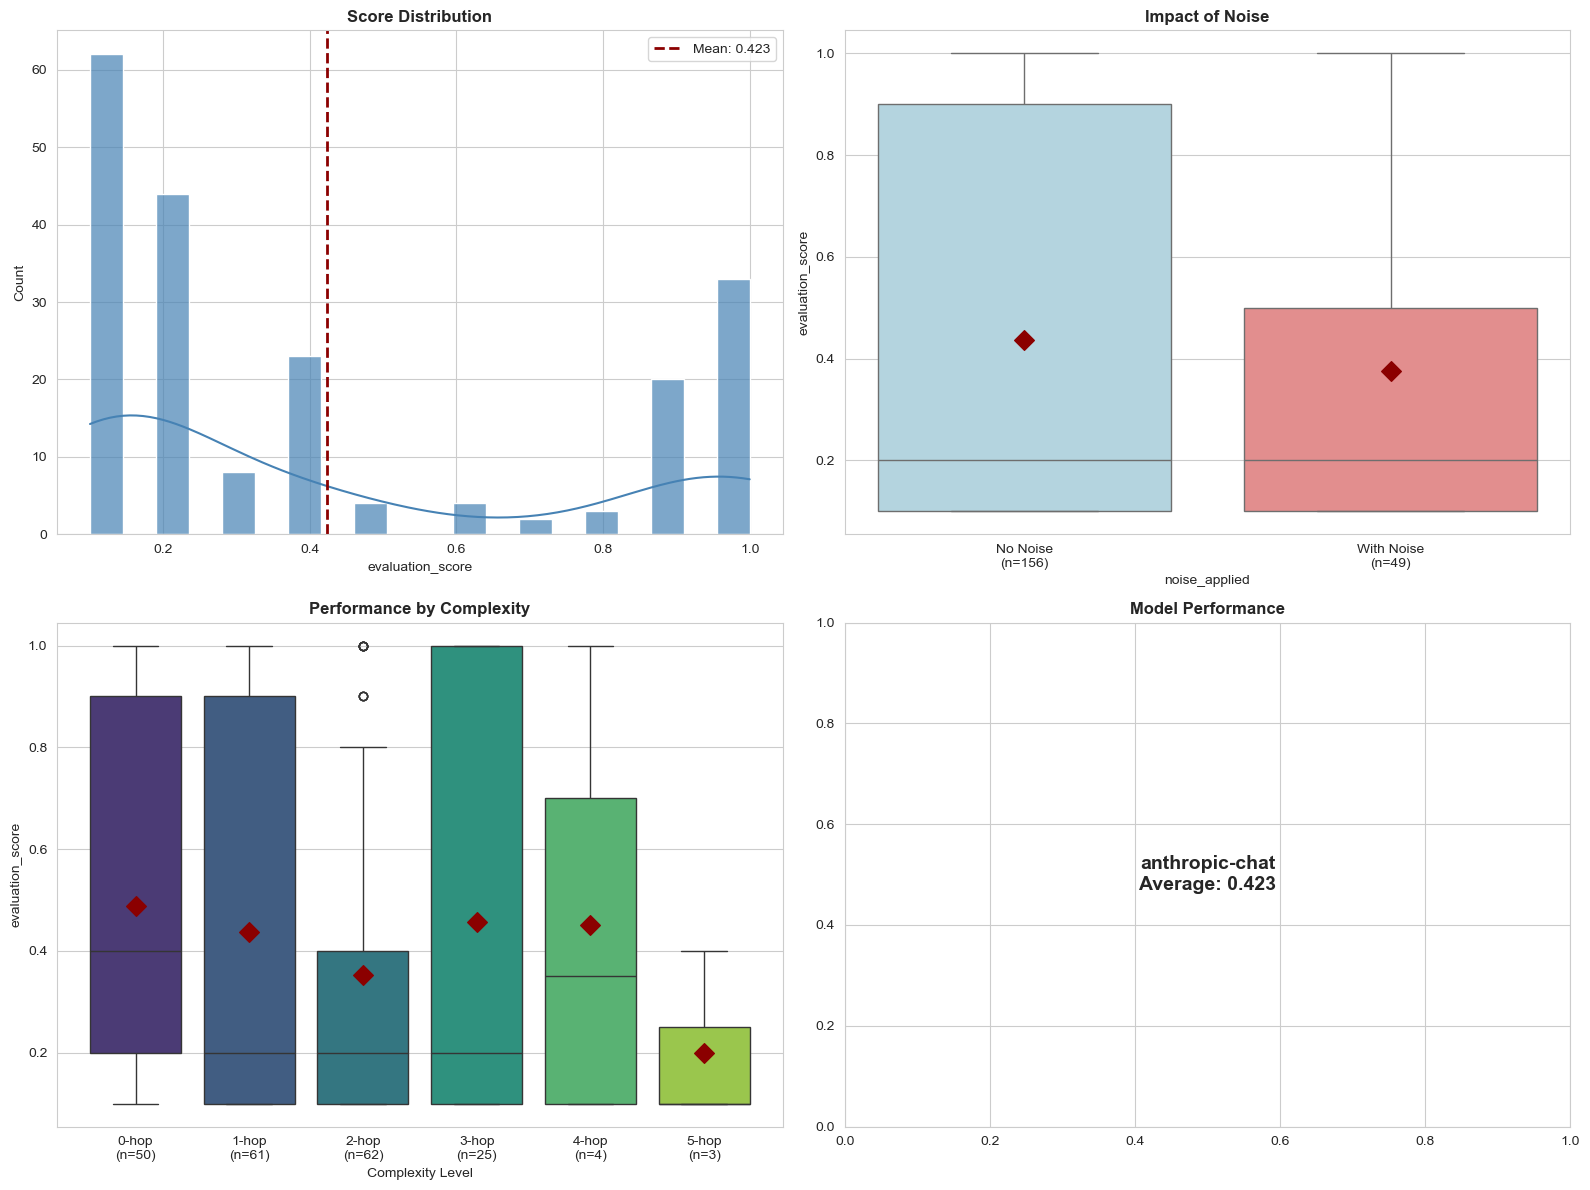


KEY COMPARISONS:
No Noise: 0.438 ± 0.359
With Noise: 0.376 ± 0.330

COMPLEXITY BREAKDOWN:
0-hop: 0.488 ± 0.332 (n=49.0)
1-hop: 0.437 ± 0.371 (n=60.0)
2-hop: 0.353 ± 0.312 (n=62.0)
3-hop: 0.456 ± 0.428 (n=25.0)
4-hop: 0.450 ± 0.436 (n=4.0)
5-hop: 0.200 ± 0.173 (n=3.0)

SINGLE MODEL ANALYSIS (anthropic-chat):
Mean: 0.423 ± 0.352 (n=205)


In [35]:
# Or use static Seaborn plots
result = analyze_evaluation_scores(results)

In [36]:
result.head()

,question,cypher,query_type,complexity,noise_applied,model,database,validated,result,answer,noise_type,tools,generated_answer,evaluation_score,evaluation_reasoning,evaluation_raw,error
0,What's Microsoft Corporation's revenue?,MATCH (o:Organization {name: 'Microsoft Corpor...,Direct Property Access,0-hop,False,anthropic-chat,companies,True,[{'company_revenue': 198270000000.0}],"According to the data, Microsoft Corporation's...",No Noise,[],As of the last fiscal year ending in June 2023...,0.7,Comparing the generated answer with the real a...,<reasoning>\nComparing the generated answer wi...,NaN
1,How many employees does SAP have?,MATCH (o:Organization {name: 'SAP'}) RETURN o....,Direct Property Access,0-hop,False,anthropic-chat,companies,True,[{'employee_count': 111961}],"According to the data, SAP has 111,961 employees.",No Noise,[],"As of the latest available data in 2023, SAP h...",0.8,The generated answer is close to the actual nu...,<reasoning>\nThe generated answer is close to ...,NaN
2,Tell me Mircosoft Corporation's motto,MATCH (o:Organization {name: 'Microsoft Corpor...,Direct Property Access,0-hop,True,anthropic-chat,companies,True,[{'company_motto': 'We’re on a mission to empo...,"Microsoft Corporation's motto is: ""We're on a ...",typo,[],"Microsoft Corporation's motto is ""Empowering u...",0.7,The generated answer contains a partially accu...,<reasoning>\nThe generated answer contains a p...,NaN
3,Is Cloud Sherpas still active?,MATCH (o:Organization {name: 'Cloud Sherpas'})...,Direct Property Access,0-hop,False,anthropic-chat,companies,True,[{'is_dissolved': True}],"No, Cloud Sherpas is not still active. The que...",No Noise,[],"No, Cloud Sherpas is no longer active. It was ...",0.9,The generated answer contains both accurate an...,<reasoning>\nThe generated answer contains bot...,NaN
4,What's the revenue of New Energy Group?,MATCH (o:Organization {name: 'New Energy Group...,Direct Property Access,0-hop,False,anthropic-chat,companies,True,[{'company_revenue': 120000000.0}],"The revenue of New Energy Group is $120,000,000.",No Noise,[],I don't have direct access to real-time or pri...,0.3,The generated answer does not provide the spec...,<reasoning>\nThe generated answer does not pro...,NaN


In [37]:
result.to_csv("eval_results.csv", index=False)